# Shampoo Sale Forecasting Using LSTM and Keras

## 1. Data and basic analysis

In [4]:
# from pandas import read_csv
# from pandas import datetime
import matplotlib.pyplot as plt
import pandas as pd

Month
1901-01-01    266.0
1901-02-01    145.9
1901-03-01    183.1
1901-04-01    119.3
1901-05-01    180.3
Name: Sales of shampoo over a three year period, dtype: float64


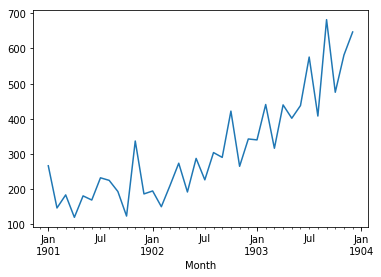

In [6]:
# load dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')
series = pd.read_csv('data/shampoo-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# summarize first few rows
print(series.head())

# line plot
series.plot()
plt.show()